# What percentage of edits that add new information include at least one new reference

**Megan Neisler, Senior Data Scientist, Wikimedia Foundation**

** Last update: 08 August 2023**

[TASK](https://phabricator.wikimedia.org/T332848) | [CODEBASE](https://gitlab.wikimedia.org/mneisler/edit-check-references-2023)

In [144]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse)
    library(glue)
    # Tables:
    library(gt)
    library(gtsummary)
})

In [64]:
options(repr.plot.width = 15, repr.plot.height = 10)
# Suppress summarise info
options(dplyr.summarise.inform = FALSE)

In [145]:
# set privact threshold
threshold <- 50

# Purpose and methodology

The purpose of this analysis is the learn the proportion of new content edits made with Visual Editor in the main namespace that including at least one new reference. 

Project specific breakdowns needed for the following wikis:
en.wiki, fr.wiki, sw.wiki, ar.wiki, pt.wiki, ha.wiki, ig.wiki, af.wiki, yo.wiki, de.wiki

This is done by using the following new change tags:

In [T325713](https://phabricator.wikimedia.org/T325713), we introduced a hidden change tag to identify all edits made using the visual editor to pages in the main namespace that involve an edit where people add a net new reference. This tag is called `editcheck-newreference`. Deployed on July 6th

In [T333714](https://phabricator.wikimedia.org/T333714), we also introduce a hidden change tag to identify all edits made using the visual editor that meet the edit check heurist conditions defined in [T324733](https://phabricator.wikimedia.org/T324733) with the exception that this tag does not consider whether a new reference was added as part of the edit in question. This tag is called `editcheck-newcontent`. Deployed on July 3rd.

Data comes comes the `mediawiki_revision_tags_change` table. Data reviewed was limited to revisions with a timestamp of july 7th or later to reflect when both change tags were deployed. 


# Explore Data

In [108]:
tag_data <-
  read.csv(
    file = 'Data/tag_data.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads all revert data

In [109]:
# Clean data

# group user edit count 
tag_data <- tag_data %>%
 mutate(
    user_edit_count_group = case_when(
      user_edit_count == 'NA'  ~ "unregistered",
      user_edit_count == 0 ~ "new editor",
      user_edit_count  > 0 & user_edit_count < 100 ~ "1-99 edits",
       user_edit_count  >= 100 & user_edit_count <= 500 ~ "100-500 edits",
      user_edit_count > 500 ~ '500+ edits'  
    )
  ) 

# add factor levels to exp level
tag_data$user_edit_count_group <-
  factor(tag_data$user_edit_count_group,
         levels = c("new editor", "1-99 edits", "100-500 edits", "500+ edits"))

# Overall

## Proportion of edits

In [20]:
new_content_ref_overall <- tag_data %>%
    summarise(
        n_edits = n_distinct(rev_id),
        n_edit_w_refs = n_distinct(rev_id[includes_new_ref > 0]),
        pct_new_content_edits = n_edit_w_refs/n_edits * 100)

new_content_ref_overall

n_edits n_edit_w_refs pct_new_content_edits
1 88523   18011         20.34612

## Proportion of users

In [94]:
new_content_ref_overall_users <- tag_data %>%
    summarise(
        n_users = n_distinct(user),
        n_users_w_refs = n_distinct(user[includes_new_ref > 0]),
        pct_new_content_users = n_users_w_refs/n_users * 100)

new_content_ref_overall_users

n_users n_users_w_refs pct_new_content_users
1 32927   7008           21.28345

Overall about 21% of distinct users that posted a new content edits made across all Wikipedias made with visual editor included at least 1 new reference.

# By Logged In Status

## Proportion of Edits

In [76]:
new_content_ref_bystatus <- tag_data %>%
    group_by(user_status) %>%
    summarise(
        n_edits = n_distinct(rev_id),
        n_edit_w_refs = n_distinct(rev_id[includes_new_ref > 0]),
        pct_new_content_edits = n_edit_w_refs/n_edits)

new_content_ref_bystatus

user_status  n_edits n_edit_w_refs pct_new_content_edits
1 registered   70305   15613         0.2220752            
2 unregistered 18228    2400         0.1316656

# By User Experience

## Proportion of edits

In [23]:
new_content_ref_byexp <- tag_data %>%
    filter(user_status != 'unregistered') %>% #remove logged out users
    group_by(user_edit_count_group) %>%
    summarise(
        n_edits = n_distinct(rev_id),
        n_edit_w_refs = n_distinct(rev_id[includes_new_ref > 0]),
        pct_new_content_edits = round(n_edit_w_refs/n_edits,2))

new_content_ref_byexp

user_edit_count_group n_edits n_edit_w_refs pct_new_content_edits
1 new editor             3763    438          0.12                 
2 1-100 edits           19704   3289          0.17                 
3 100-500 edits          9740   2181          0.22                 
4 500+ edits            37101   9706          0.26

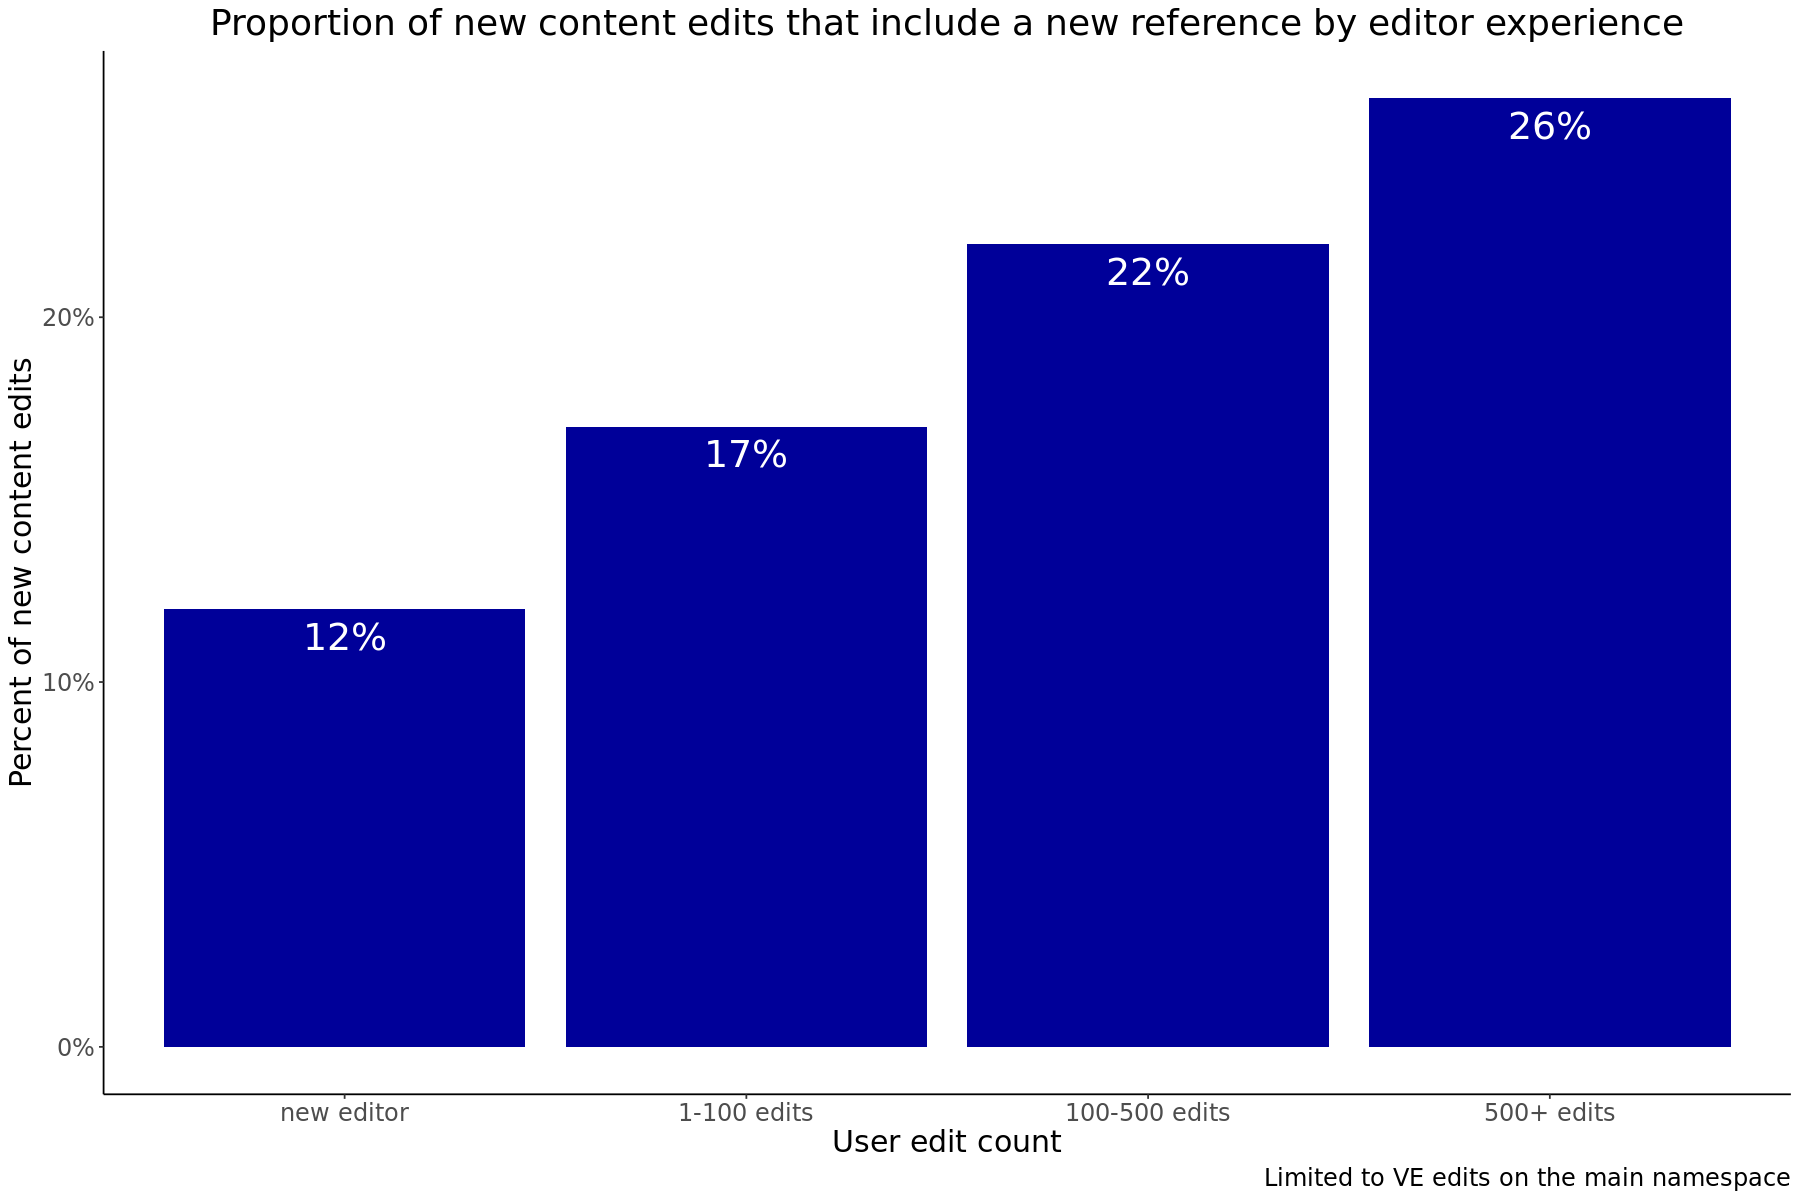

In [24]:
p <- new_content_ref_byexp %>%
        ggplot(aes(x = user_edit_count_group, y= pct_new_content_edits)) +
        geom_col(position = 'dodge', fill = '#000099') +
        geom_text(aes(label = paste0(pct_new_content_edits * 100,'%')), color = "white", vjust=1.5, size = 8) +
        labs (x = "User edit count",
              y = "Percent of new content edits",
             title = "Proportion of new content edits that include a new reference by editor experience",
             caption = "Limited to VE edits on the main namespace") +
        scale_y_continuous(labels = scales::percent) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "none")
      
p


## Proportion of users

In [79]:
new_content_ref_byexp_users <- tag_data %>%
    filter(user_edit_count_group != 'unregistered') %>% #remove logged out users
    group_by(user_edit_count_group) %>%
    summarise(
        n_users = n_distinct(user),
        n_users_w_refs = n_distinct(user[includes_new_ref > 0]),
        pct_new_content_users = n_users_w_refs/n_users)

new_content_ref_byexp_users

user_edit_count_group n_users n_users_w_refs pct_new_content_users
1 new editor             3679    429           0.1166078            
2 1-100 edits           10170   2016           0.1982301            
3 100-500 edits          3036    998           0.3287220            
4 500+ edits             5057   2380           0.4706348

## By Wiki and Experience Level

In [148]:
new_content_ref_byexp_wiki <- tag_data %>%
    filter(wiki %in% c('enwiki', 'frwiki', 'swwiki', 'arwiki', 'ptwiki', 'hawiki', 
                       'igwiki', 'afwiki', 'yowiki', 'dewiki') 
        ,user_status != 'unregistered') %>% #remove logged out users
    group_by(wiki, user_edit_count_group) %>%
    summarise(
        n_edits = n_distinct(rev_id),
        n_edit_w_refs = n_distinct(rev_id[includes_new_ref > 0]),
        pct_new_content_edits = round(n_edit_w_refs/n_edits,2))


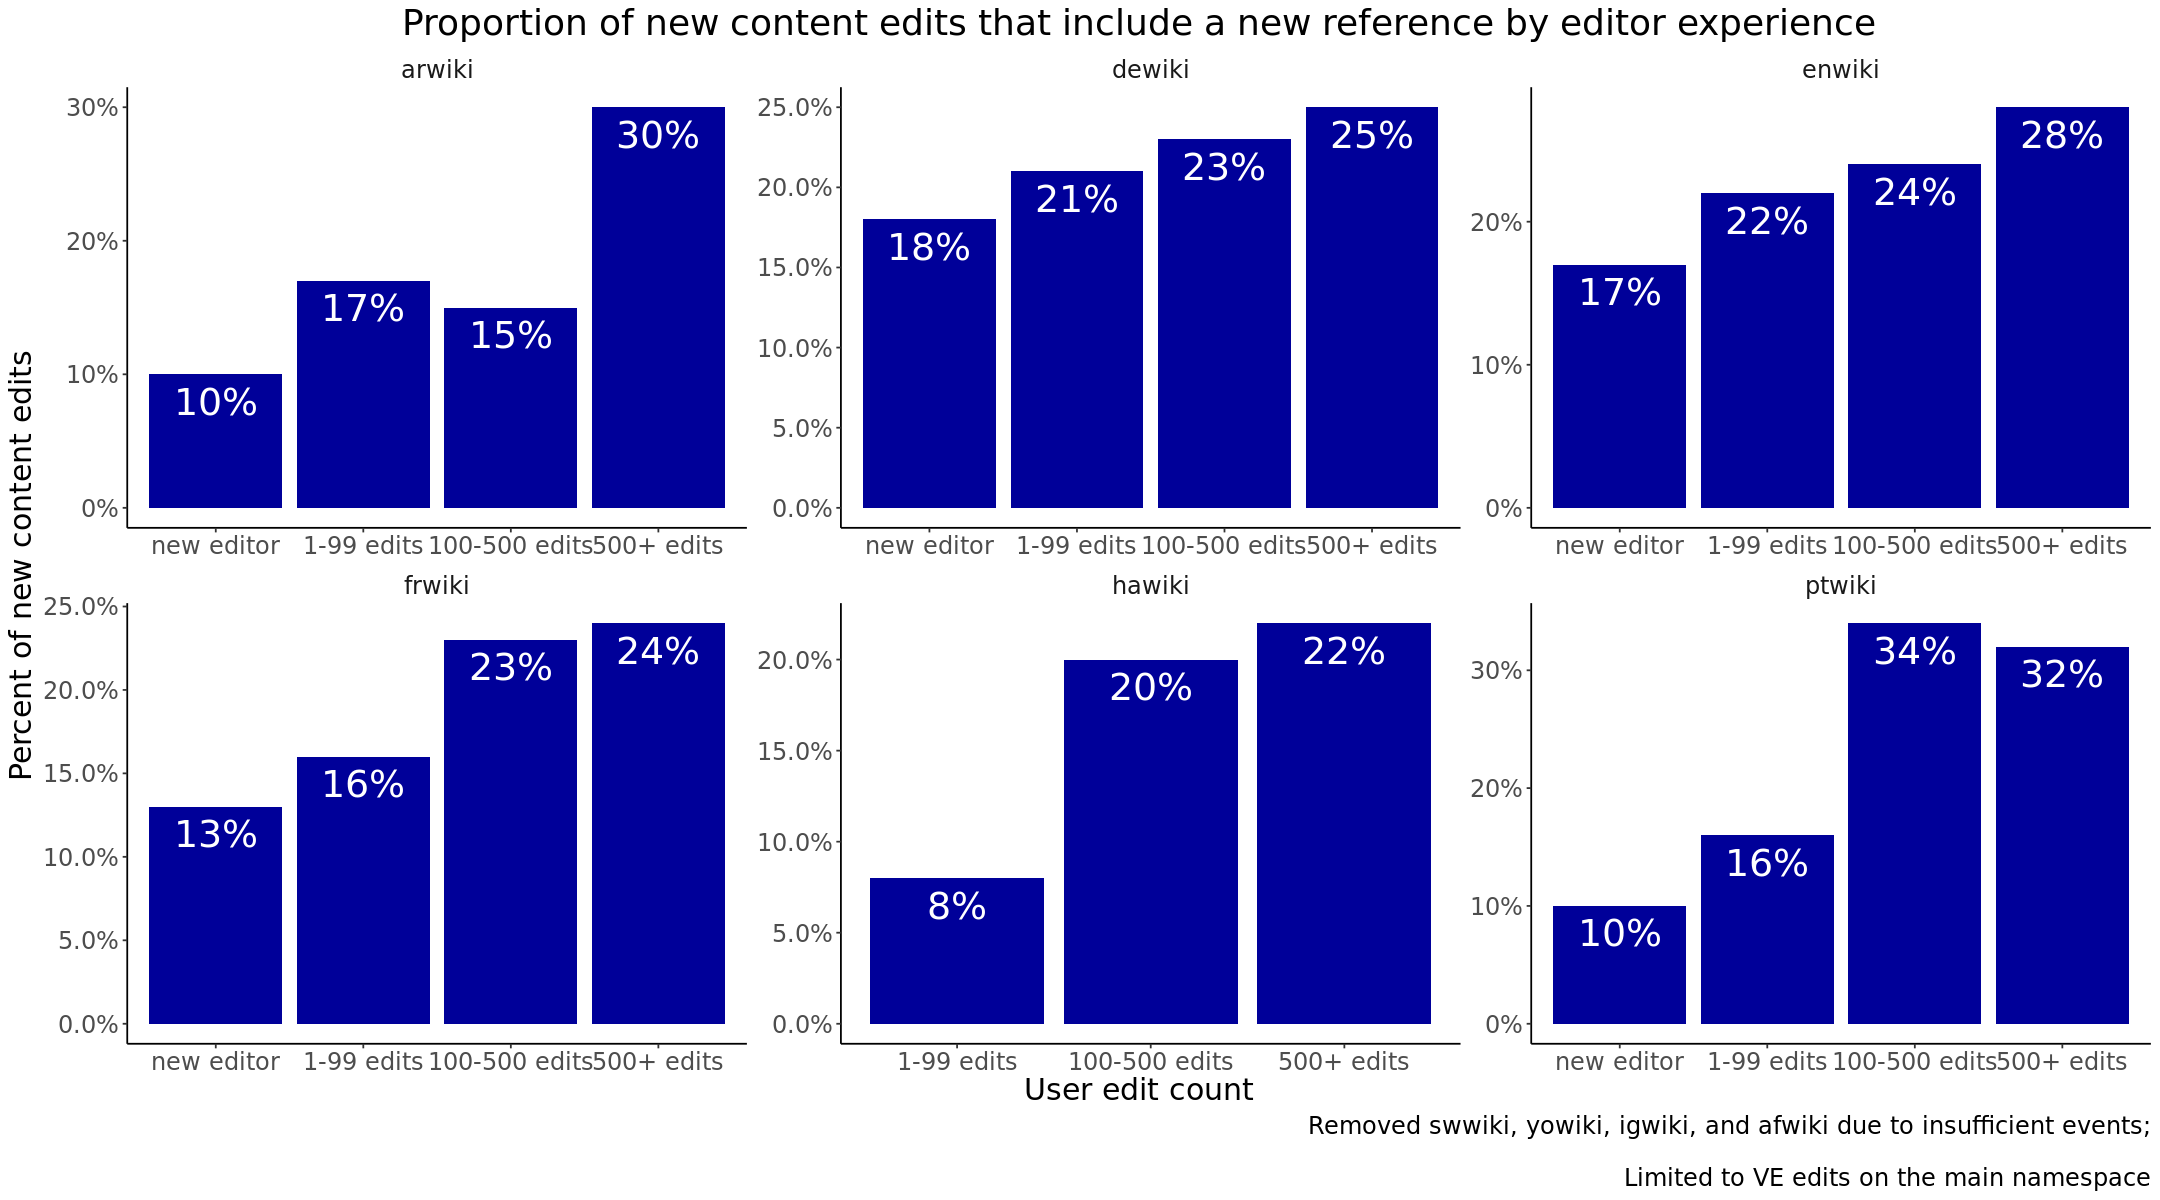

In [120]:
options(repr.plot.width = 18, repr.plot.height = 10)
p <- new_content_ref_byexp_wiki %>% 
         filter(!wiki %in% c('swwiki', 'yowiki', 'igwiki', 'afwiki')) %>%
        ggplot(aes(x = user_edit_count_group, y= pct_new_content_edits)) +
        geom_col(position = 'dodge', fill = '#000099') +
        geom_text(aes(label = paste0(pct_new_content_edits * 100,'%')), color = "white", vjust=1.5, size = 8) +
        facet_wrap(~wiki, scales = "free") +
        labs (x = "User edit count",
              y = "Percent of new content edits",
             title = "Proportion of new content edits that include a new reference by editor experience",
             caption = "Removed swwiki, yowiki, igwiki, and afwiki due to insufficient events;
            \n Limited to VE edits on the main namespace") +
        scale_y_continuous(labels = scales::percent) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "none")
      
p


Note: swwiki, afwiki,  igwiki and yowiki did not have sufficient events for analysis. At least one more month of data is likely needed to include per wiki breakdowns for these wikis. 

When broken down by project, we see roughly similar overall trends with new editors least likely to publish a new content edit with a new reference and senior contributors more likely. Some initial observations:
* Hawiki did not have any new editors that published an edit on a main namespace during the reviewed period and only 8% of edits by junior contributors on this project included at least one new reference (compared to 22% at English Wikipedia).
* At both arwiki and ptwiki, senior editors with over 500 edits are 3 times more likely to publish an edit with a new reference compared to new editors. This difference is higher than the difference observed between senior and new editors at the other reviewed wikis.
* At Ptwiki, we observed the highest proportion of new content edits with new references by senior editors (34% for editors with 100-500 edits and 32% for editors with over 500 edits)
* The other larger wikis enwiki, dewiki and frwiki follow overall trends with the percent of new content edits that include a reference consistently increasing with experience. 


# What percentage of these edits are reverted?

## within 48 hours

In [29]:
new_content_ref_byrevert_48 <- tag_data %>%
    summarise(
        n_edits_w_refs = n_distinct(rev_id[includes_new_ref > 0]),
        n_edit_w_refs_reverted = n_distinct(rev_id[includes_new_ref > 0 & is_reverted_48hrs > 0]),
        pct_w_ref_reverted = n_edit_w_refs_reverted/n_edits_w_refs)
             

new_content_ref_byrevert_48

n_edits_w_refs n_edit_w_refs_reverted pct_w_ref_reverted
1 18011          1045                   0.0580201

## no time limits

In [30]:
new_content_ref_byrevert <- tag_data %>%
    summarise(
        n_edits_w_refs = n_distinct(rev_id[includes_new_ref > 0]),
        n_edit_w_refs_reverted = n_distinct(rev_id[includes_new_ref > 0 & is_reverted > 0]),
        pct_w_ref_reverted = n_edit_w_refs_reverted/n_edits_w_refs)
             

new_content_ref_byrevert

n_edits_w_refs n_edit_w_refs_reverted pct_w_ref_reverted
1 18011          1120                   0.06218422

About 6% of these edits were reverted within 48 hours.

# How does that compare to the revert rate of the new content edits that do not include a reference?

## within 48 hours

In [31]:
new_content_noref_byrevert_48 <- tag_data %>%
    summarise(
        n_edits_no_refs = n_distinct(rev_id[includes_new_ref == 0]),
        n_edits_no_refs_reverted = n_distinct(rev_id[includes_new_ref == 0 & is_reverted_48hrs > 0]),
        pct_no_ref_reverted = n_edits_no_refs_reverted/n_edits_no_refs)
             

new_content_noref_byrevert_48

n_edits_no_refs n_edits_no_refs_reverted pct_no_ref_reverted
1 70519           8127                     0.1152455

## no time limits

In [32]:
new_content_noref_byrevert <- tag_data %>%
    summarise(
        n_edits_no_refs = n_distinct(rev_id[includes_new_ref == 0]),
        n_edits_no_refs_reverted = n_distinct(rev_id[includes_new_ref == 0 & is_reverted > 0]),
        pct_no_ref_reverted = n_edits_no_refs_reverted/n_edits_no_refs)
             

new_content_noref_byrevert

n_edits_no_refs n_edits_no_refs_reverted pct_no_ref_reverted
1 70519           8708                     0.1234845

11% of new content edits that do not include a reference were reverted.

## Revert rate by Experience Level
Limited to edits reverted within 48 hours

### Revert rate of new content edits that do include a reference

In [113]:
new_content_ref_byrevert_48_exp <- tag_data %>%
    group_by(user_edit_count_group) %>%
    summarise(
        n_edits_w_refs = n_distinct(rev_id[includes_new_ref > 0]),
        n_edit_w_refs_reverted = n_distinct(rev_id[includes_new_ref > 0 & is_reverted_48hrs > 0]),
        pct_w_ref_reverted = n_edit_w_refs_reverted/n_edits_w_refs)
             

new_content_ref_byrevert_48_exp

user_edit_count_group n_edits_w_refs n_edit_w_refs_reverted
1 new editor             438            64                   
2 1-99 edits            3289           290                   
3 100-500 edits         2181            51                   
4 500+ edits            9706            73                   
5 NA                    2400           567                   
  pct_w_ref_reverted
1 0.146118721       
2 0.088172697       
3 0.023383769       
4 0.007521121       
5 0.236250000

### Revert rate of new content edits that do not include a reference

In [114]:
new_content_noref_byrevert_48_exp <- tag_data %>%
    group_by(user_edit_count_group) %>%
    summarise(
        n_edits_no_refs = n_distinct(rev_id[includes_new_ref == 0]),
        n_edits_no_refs_reverted = n_distinct(rev_id[includes_new_ref == 0 & is_reverted_48hrs > 0]),
        pct_no_ref_reverted = n_edits_no_refs_reverted/n_edits_no_refs)
             

new_content_noref_byrevert_48_exp

user_edit_count_group n_edits_no_refs n_edits_no_refs_reverted
1 new editor             3325            778                    
2 1-99 edits            16415           2480                    
3 100-500 edits          7559            219                    
4 500+ edits            27397            286                    
5 NA                    15828           4364                    
  pct_no_ref_reverted
1 0.23398496         
2 0.15108133         
3 0.02897209         
4 0.01043910         
5 0.27571392

In [ ]:
## Combine table to compare side by side

new_content_byrevert_48_exp <- new_content_ref_byrevert_48_exp %>%
    inner_join(new_content_noref_byrevert_48_exp, by = "user_edit_count_group") %>%
    select(c(1,4,7)) %>% 
    gather("refs_included","proportion_reverted", -user_edit_count_group) %>%
    mutate(refs_included =  factor(refs_included,
         levels = c( "pct_no_ref_reverted", "pct_w_ref_reverted"),
         labels = c("Does not include new ref", "Includes new ref"))) %>%
    arrange(user_edit_count_group)



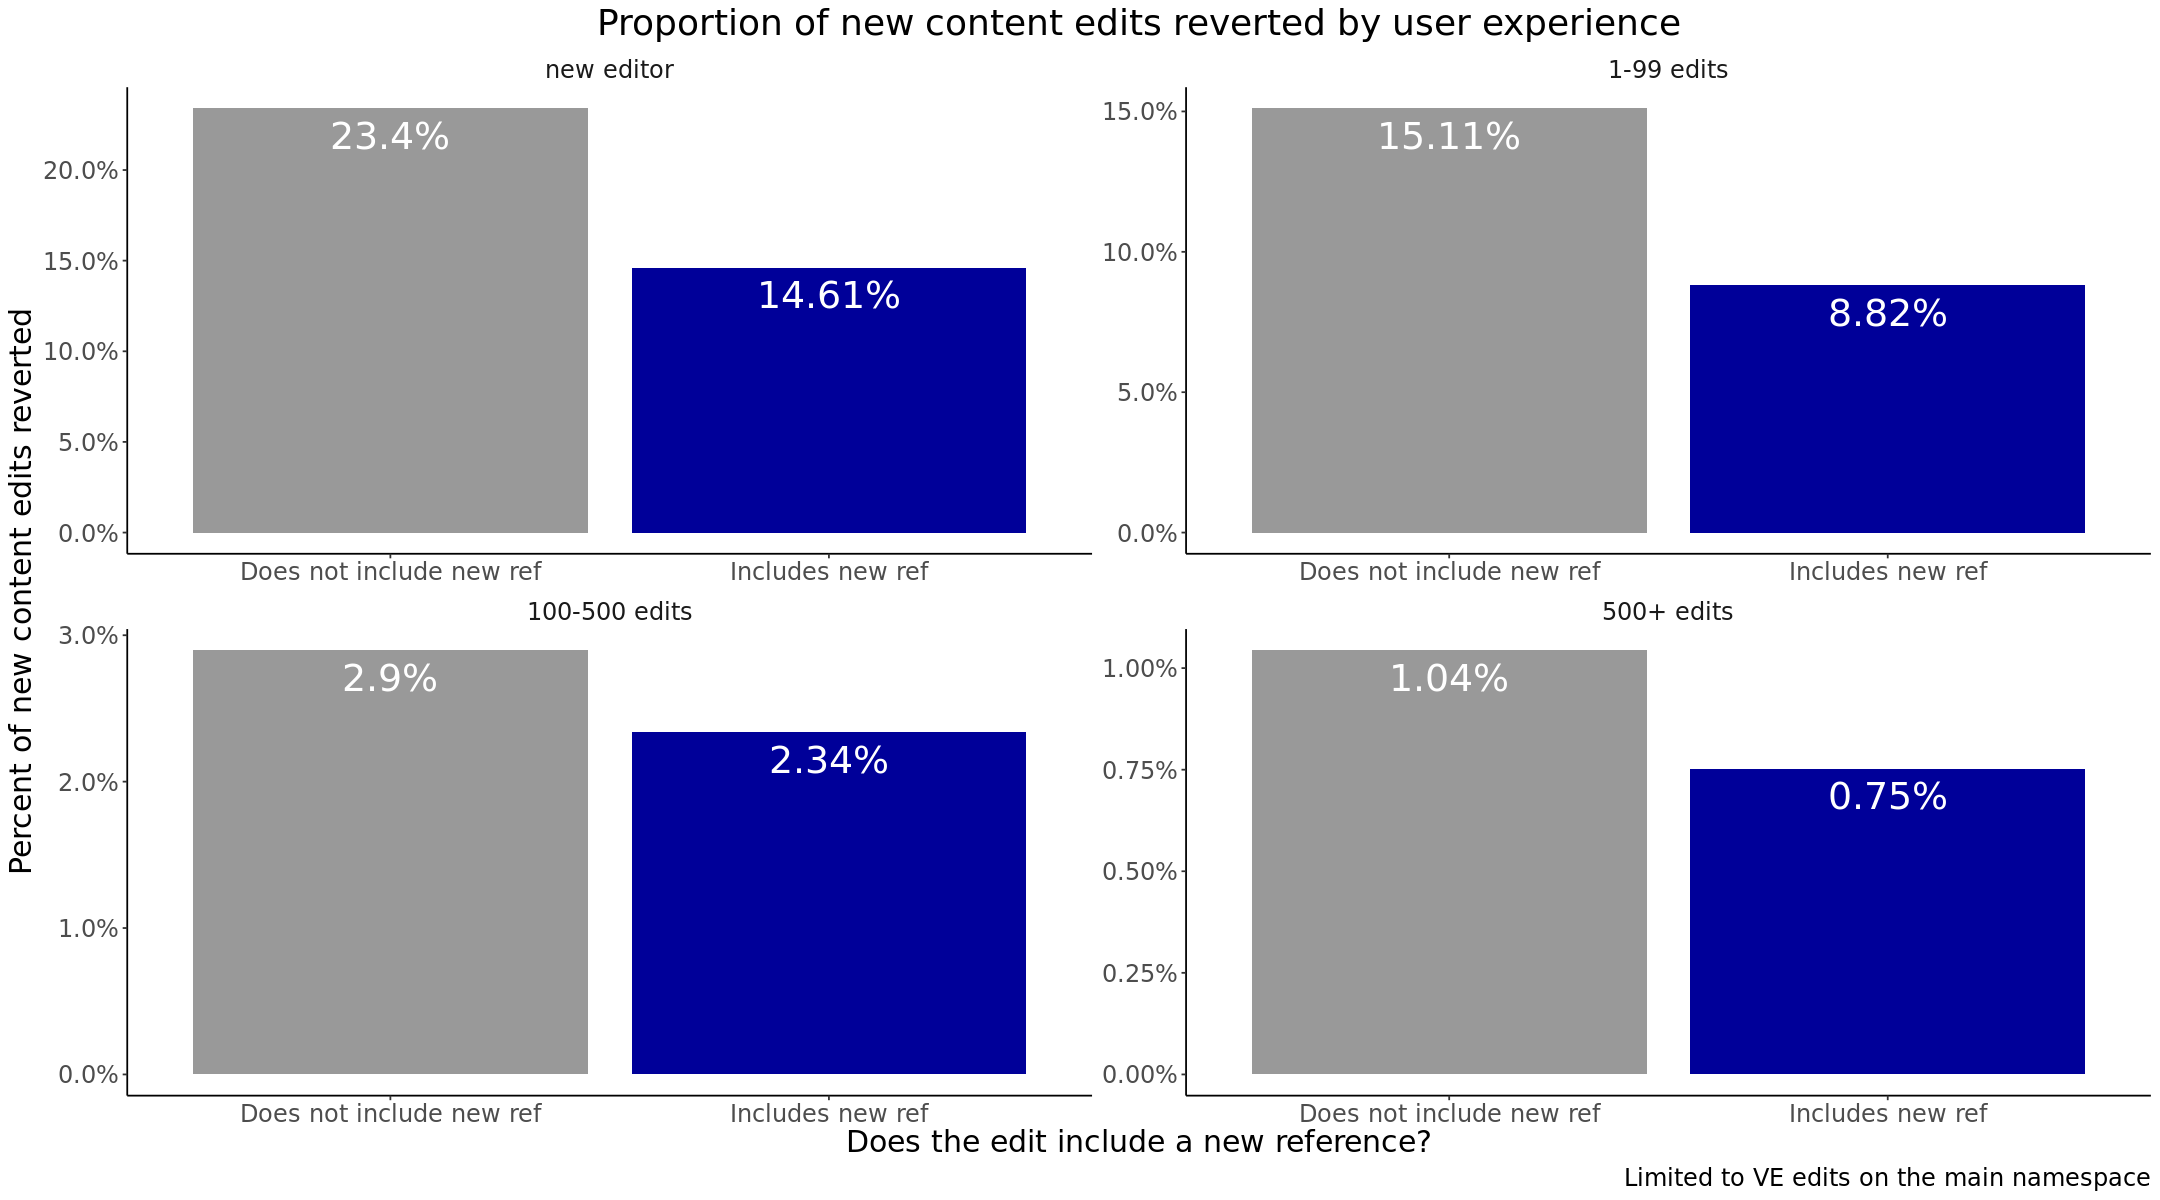

In [124]:
options(repr.plot.width = 18, repr.plot.height = 10)
p <- new_content_byrevert_48_exp  %>% 
        filter(user_edit_count_group != 'NA')  %>%
        ggplot(aes(x = refs_included, y= proportion_reverted, fill = refs_included)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste0(round(proportion_reverted * 100, 2),'%')), color = "white", vjust=1.5, size = 8) +
        facet_wrap(~user_edit_count_group, scales = "free") +
        labs (x = "Does the edit include a new reference?",
              y = "Percent of new content edits reverted",
             title = "Proportion of new content edits reverted by user experience",
             caption = "Limited to VE edits on the main namespace") +
        scale_y_continuous(labels = scales::percent) +
    scale_fill_manual(values= c("#999999", "#000099"))  + 
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "none")
      
p


Observations:
* For each editor experience level, new content edits that include at least one new reference are reverted less than new content edits without a new reference. 
*  For new editors and junior editors (under 100 edits), there's a higher percent difference between the revert rate of new content edits with a reference and without a reference. For example, the revert rate of new content edits by junior editors (under 100 edits) decreased by about 42% (15% → 8.8%) when at least one new reference was included compared to decreasing by 28% (1% -> 0.75%) for senior editors (over 500 edits).


## Revert rate by Wiki

Limited to within 48 hours

### Revert rate of new content edits that do include a reference

In [149]:
new_content_ref_byrevert_48_wiki <- tag_data %>%
 filter(wiki %in% c('enwiki', 'frwiki', 'swwiki', 'arwiki', 'ptwiki', 'hawiki', 
                       'igwiki', 'afwiki', 'yowiki', 'dewiki'))%>%
    group_by(wiki) %>%
    summarise(
        n_edits_w_refs = n_distinct(rev_id[includes_new_ref > 0]),
        n_edit_w_refs_reverted = n_distinct(rev_id[includes_new_ref > 0 & is_reverted_48hrs > 0]),
        pct_w_ref_reverted = n_edit_w_refs_reverted/n_edits_w_refs)
             


### Revert rate of new content edits that do not include a reference

In [150]:
new_content_noref_byrevert_48_wiki <- tag_data %>%
    filter(wiki %in% c('enwiki', 'frwiki', 'swwiki', 'arwiki', 'ptwiki', 'hawiki', 
                       'igwiki', 'afwiki', 'yowiki', 'dewiki'))%>%
    group_by(wiki) %>%
    summarise(
        n_edits_no_refs = n_distinct(rev_id[includes_new_ref == 0]),
        n_edits_no_refs_reverted = n_distinct(rev_id[includes_new_ref == 0 & is_reverted_48hrs > 0]),
        pct_no_ref_reverted = n_edits_no_refs_reverted/n_edits_no_refs)
             


In [151]:
## Combine table to compare side by side

new_content_byrevert_48_wiki <- new_content_ref_byrevert_48_wiki %>%
    inner_join(new_content_noref_byrevert_48_wiki, by = "wiki") %>%
    select(c(1,4,7)) %>% 
    gather("refs_included","proportion_reverted", -wiki) %>%
    mutate(refs_included =  factor(refs_included,
         levels = c( "pct_no_ref_reverted", "pct_w_ref_reverted"),
         labels = c("Does not include new ref", "Includes new ref"))) %>%
    arrange(wiki)


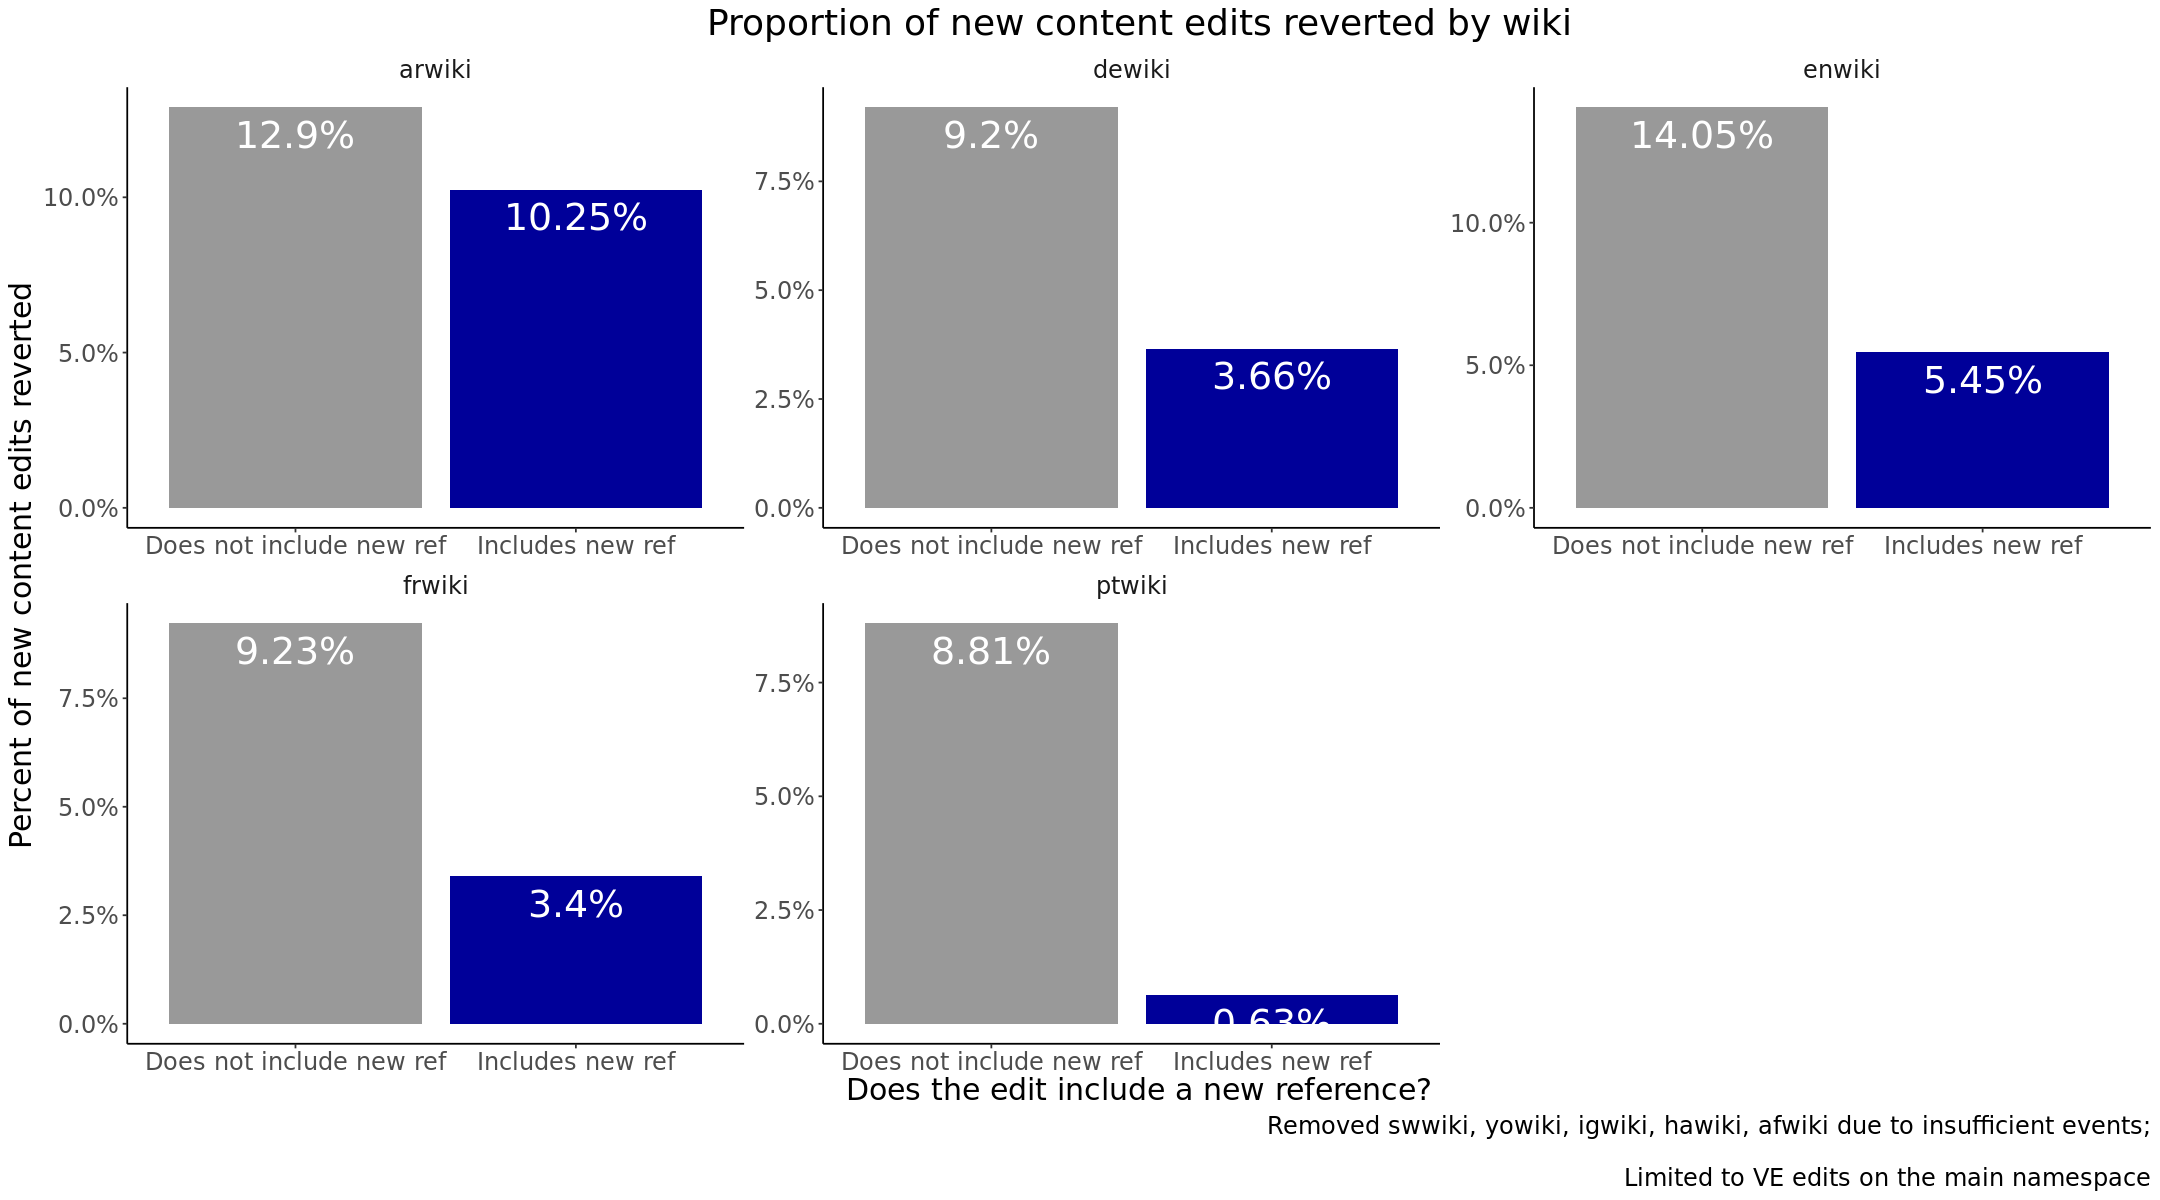

In [125]:
options(repr.plot.width = 18, repr.plot.height = 10)
p <- new_content_byrevert_48_wiki  %>% 
         filter(!wiki %in% c('swwiki', 'yowiki', 'igwiki', 'afwiki', 'hawiki')) %>%
        ggplot(aes(x = refs_included, y= proportion_reverted, fill = refs_included)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste0(round(proportion_reverted * 100, 2),'%')), color = "white", vjust=1.5, size = 8) +
        facet_wrap(~wiki, scales = "free") +
        labs (x = "Does the edit include a new reference?",
              y = "Percent of new content edits reverted",
             title = "Proportion of new content edits reverted by wiki",
             caption = "Removed swwiki, yowiki, igwiki, hawiki, afwiki due to insufficient events;
            \n Limited to VE edits on the main namespace") +
        scale_y_continuous(labels = scales::percent) +
    scale_fill_manual(values= c("#999999", "#000099"))  + 
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "none")
      
p


For each reviewed project, new content edits that include a new reference are reverted less than new content edits that do not include a new reference but the percent decrease varies per project.

* Ptwiki has the lowest revert rate (0.63%) of new content edits that include a reference.  This is about a -92% decrease (8.8% → 0.63%) from new content edits that do not include a reference.
* At arwiki, the inclusion of a reference had a smaller impact on the likelihood of an edit being reverted. At this wiki, there was a -20.5% decrease (12.9% → 10.25%) in the proportion of new content edits reverted when a new reference was included. 
* Hawiki did not have any new content edits reverted during the reviewed timeframe so it is not shown in the cart above.

# Proportion of new content edits reverted by wiki and user experience level

Limited to edits reverted within 48 hours. 

## Revert rate of new content edits that do include a reference

In [143]:
new_content_ref_byrevert_48_wiki_exp <- tag_data %>%
 filter(wiki %in% c('enwiki', 'frwiki', 'swwiki', 'arwiki', 'ptwiki', 'hawiki', 
                       'igwiki', 'afwiki', 'yowiki', 'dewiki'))%>%
    group_by(wiki, user_edit_count_group) %>%
    summarise(
        n_edits_w_refs = n_distinct(rev_id[includes_new_ref > 0]),
        n_edit_w_refs_reverted = n_distinct(rev_id[includes_new_ref > 0 & is_reverted_48hrs > 0]),
        pct_w_ref_reverted = n_edit_w_refs_reverted/n_edits_w_refs)
      

## Revert rate of new content edits that do not include a reference

In [142]:
new_content_noref_byrevert_48_wiki_exp <- tag_data %>%
    filter(wiki %in% c('enwiki', 'frwiki', 'swwiki', 'arwiki', 'ptwiki', 'hawiki', 
                       'igwiki', 'afwiki', 'yowiki', 'dewiki'))%>%
    group_by(wiki, user_edit_count_group) %>%
    summarise(
        n_edits_no_refs = n_distinct(rev_id[includes_new_ref == 0]),
        n_edits_no_refs_reverted = n_distinct(rev_id[includes_new_ref == 0 & is_reverted_48hrs > 0]),
        pct_no_ref_reverted = n_edits_no_refs_reverted/n_edits_no_refs)



In [141]:
## Combine table to compare side by side

new_content_byrevert_48_wiki_exp <- new_content_ref_byrevert_48_wiki_exp %>%
    inner_join(new_content_noref_byrevert_48_wiki_exp, by = c("wiki", "user_edit_count_group")) %>%
    select(c(1,2,5,8)) %>% 
    gather("refs_included","proportion_reverted", - c(wiki, user_edit_count_group)) %>%
    mutate(refs_included =  factor(refs_included,
         levels = c( "pct_no_ref_reverted", "pct_w_ref_reverted"),
         labels = c("Does not include new ref", "Includes new ref"))) %>%
    arrange(wiki)



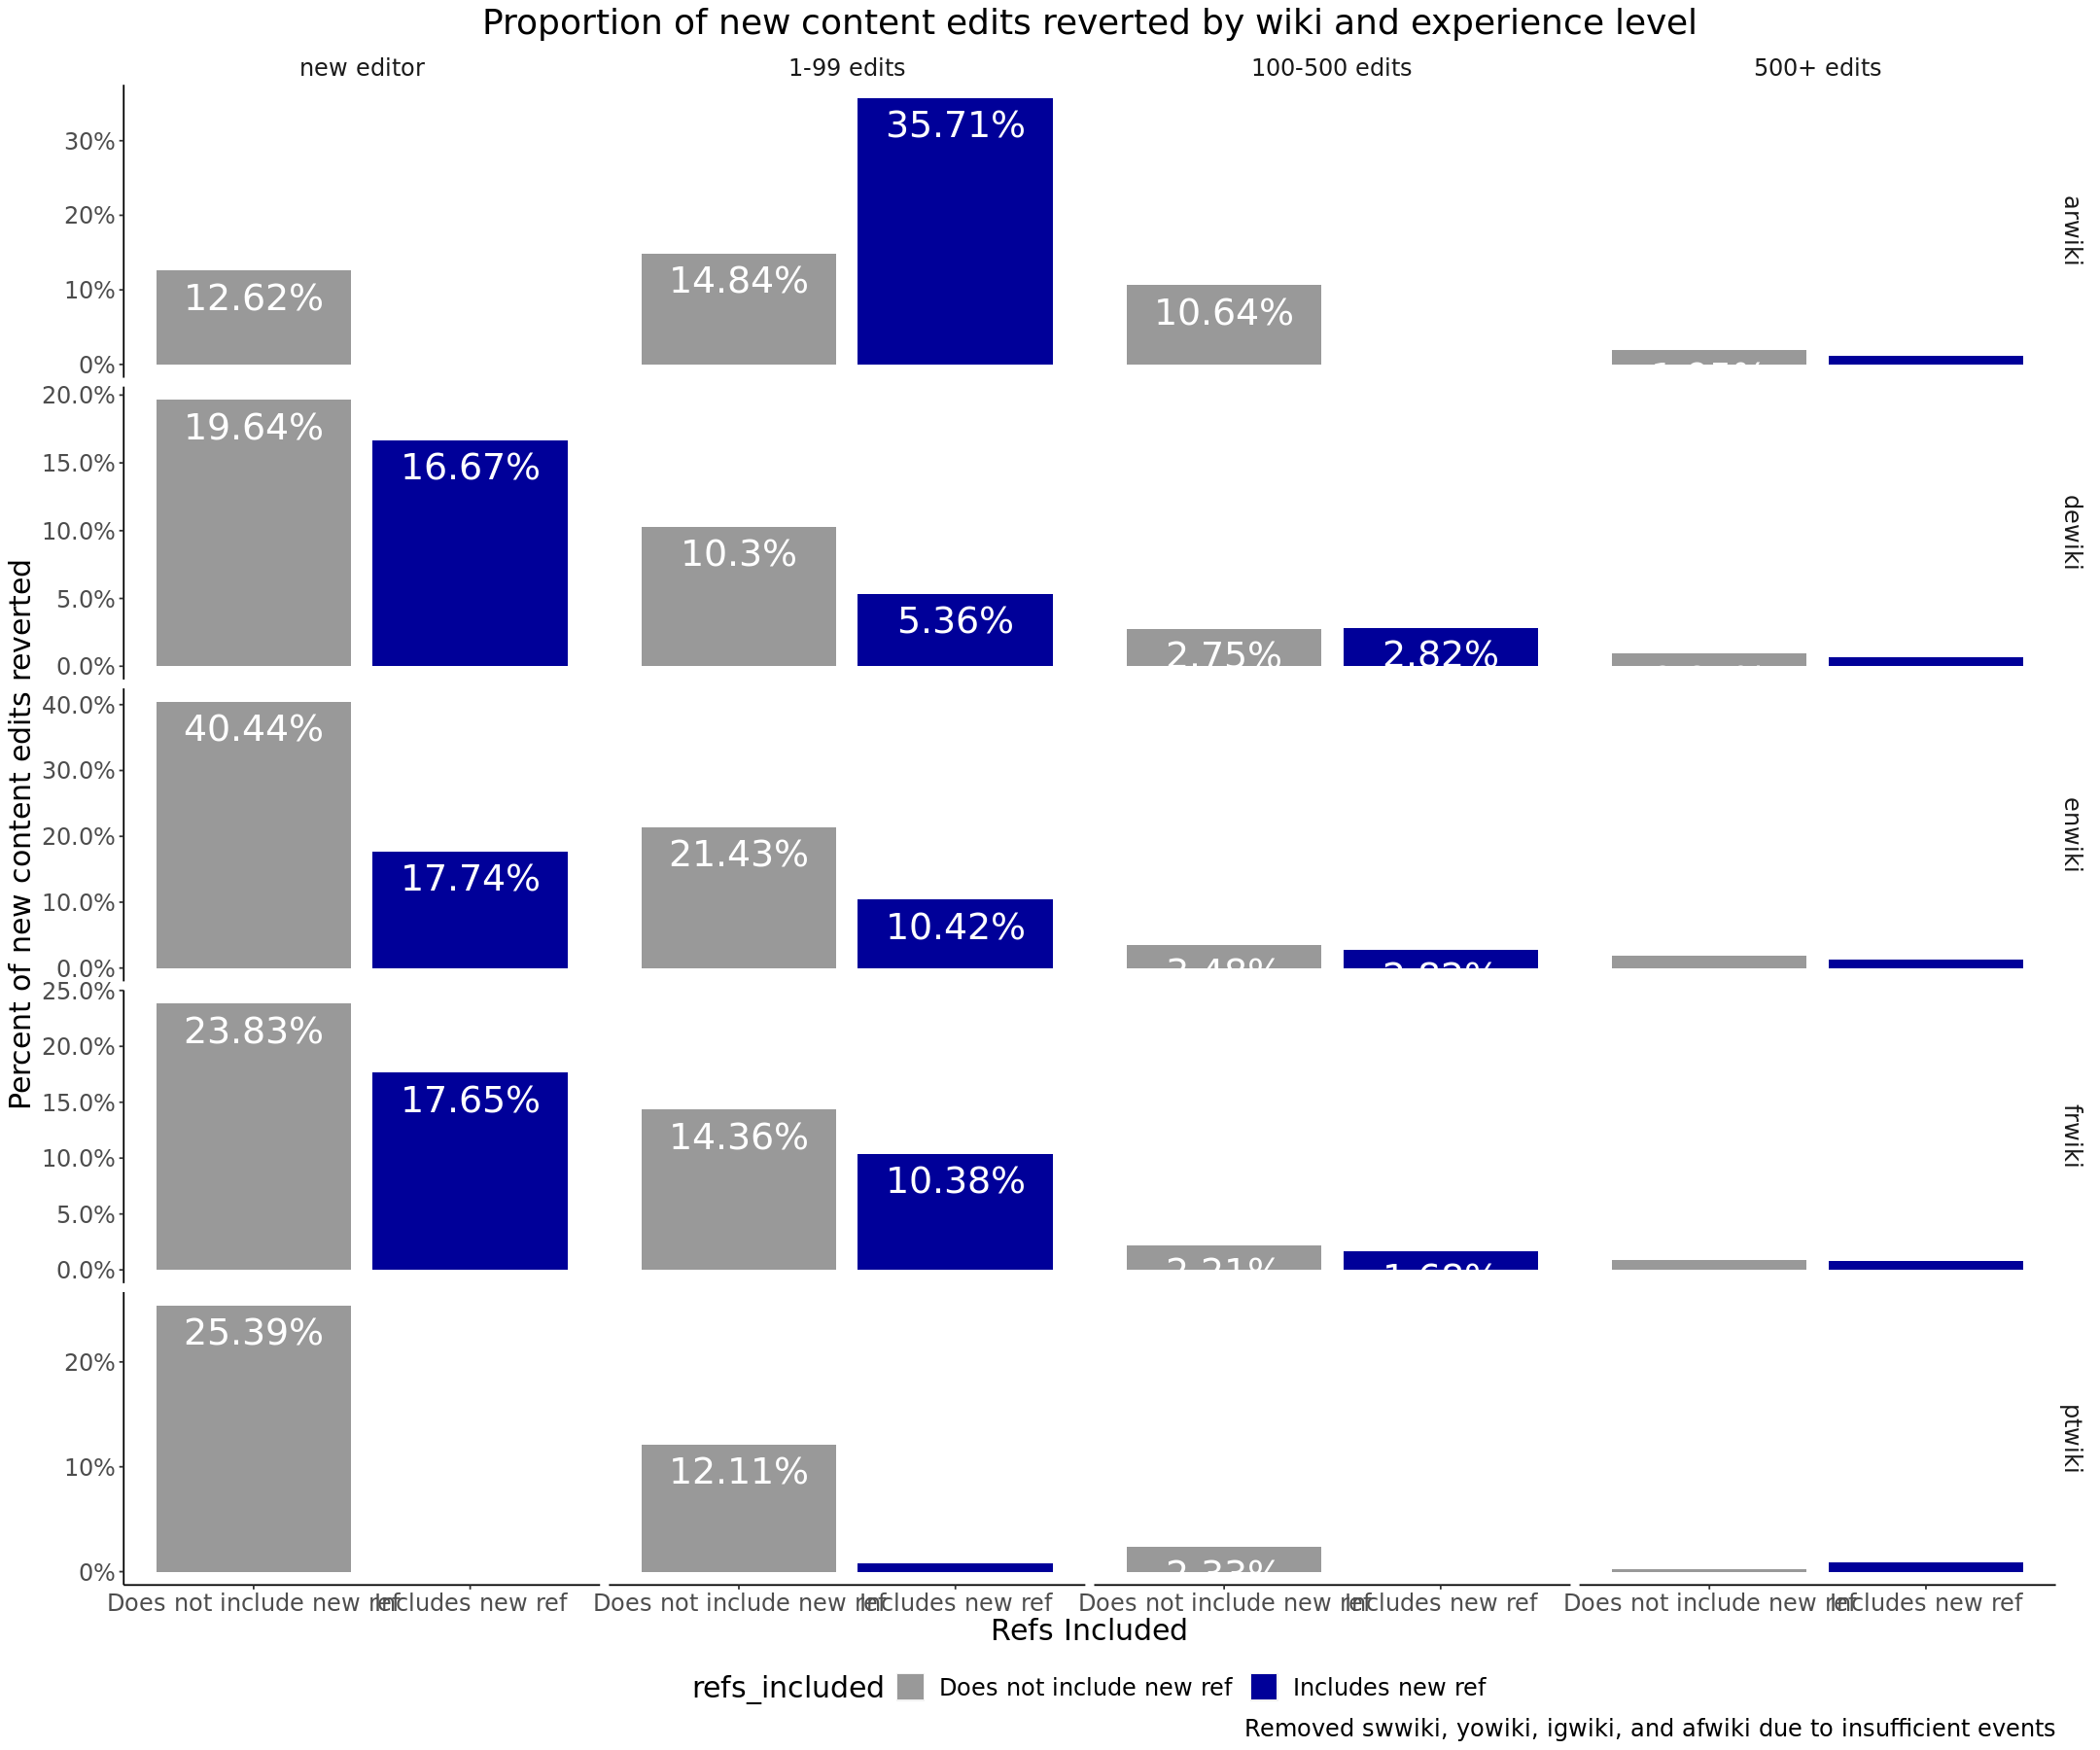

In [140]:
options(repr.plot.width = 18, repr.plot.height = 15)
p <- new_content_byrevert_48_wiki_exp   %>% 
         filter(!wiki %in% c('swwiki', 'yowiki', 'igwiki', 'afwiki', 'hawiki'),
               user_edit_count_group != 'NA') %>%
        ggplot(aes(x = refs_included, y= proportion_reverted, fill = refs_included)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste0(round(proportion_reverted * 100, 2),'%')), color = "white", vjust=1.5, size = 8) +
        facet_grid(vars(wiki),vars(user_edit_count_group), scales = "free_y") +
        labs (x = "Refs Included",
              y = "Percent of new content edits reverted",
             title = "Proportion of new content edits reverted by wiki and experience level",
             caption = "Removed swwiki, yowiki, igwiki, hawiki, afwiki due to insufficient events") +
        scale_y_continuous(labels = scales::percent) +
    scale_fill_manual(values= c("#999999", "#000099"))  + 
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


**Observations:**
* Enwiki, frwiki, and dewiki had similar trends with new content edits by new editors reverted more frequently than more senior editors. If the new content edit included a new reference, then the proportion of edits reverted decreased for each experience level. Higher percent decreases were observed for new editors and junior contributors compared to senior editors. 
* At enwiki, 40.4% of new content edits by new editors without a reference are reverted. This is a 50% percent increase compared to the rate observed on other wikis. 
* At ptwiki, a very small proportion of the 500 new content edits that included a reference were reverted (0.6%). These few reverted edits were completed by junior editors with between 1-99 edits and senior editors. 
* At arwiki, a high proportion (35.7%) of new content edits by junior editors that included a reference were reverted. In contrast to other per wiki and overall trends, this is higher than the observed revert rate (14.8%)  of new content edits that did not include a reference. 

# Overall By Wiki 

## Proportion of edits

In [152]:
new_content_ref_bywiki <- tag_data %>%
    filter(wiki %in% c('enwiki', 'frwiki', 'swwiki', 'arwiki', 'ptwiki', 'hawiki', 
                       'igwiki', 'afwiki', 'yowiki', 'dewiki'))%>%
    group_by(wiki)  %>%
    summarise(
        n_edits = n_distinct(rev_id),
        n_edit_w_refs = n_distinct(rev_id[includes_new_ref > 0]),
        pct_new_content_edits = n_edit_w_refs/n_edits)  %>%
    arrange(desc(pct_new_content_edits))


## Proportion by Users

In [153]:
new_content_ref_bywiki_users <- tag_data %>%
filter(wiki %in% c('enwiki', 'frwiki', 'swwiki', 'arwiki', 'ptwiki', 'hawiki', 
                       'igwiki', 'afwiki', 'yowiki', 'dewiki'))%>%
    group_by(wiki)  %>%
    summarise(
        n_users = n_distinct(user),
        n_users_w_refs = n_distinct(user[includes_new_ref > 0]),
        pct_new_content_users = n_users_w_refs/n_users) %>%
    arrange(desc(pct_new_content_users))
